<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Wide-Residual-Networks" data-toc-modified-id="Wide-Residual-Networks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Wide Residual Networks</a></span><ul class="toc-item"><li><span><a href="#Sources" data-toc-modified-id="Sources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Sources</a></span><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Wide-Residual-Networks" data-toc-modified-id="Wide-Residual-Networks-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Wide Residual Networks</a></span></li></ul></li><li><span><a href="#Comparison-w-Resnet" data-toc-modified-id="Comparison-w-Resnet-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparison w Resnet</a></span><ul class="toc-item"><li><span><a href="#Comparing-speed-of-execution" data-toc-modified-id="Comparing-speed-of-execution-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Comparing speed of execution</a></span></li></ul></li></ul></li></ul></div>

# Wide Residual Networks

In [1]:
#GETTING THE CIFAR DATASET READY FOR EXPERIMENTATION
import tensorflow as     tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *

#CIFAR DATA AND NETWORK UTILITY FUNCTIONS
from utils.cifar_functions import *

dataset_train, dataset_test = load_cifar()

## Sources
- [1](https://arxiv.org/pdf/1605.07146.pdf)


### Intro

ResNets are great for allowing deep networkss, but long thin networks can suffer from a lack of feature reuse. Early info cant be accessed deepdeep in the network. One method of combatting this issue is __stochastic depth__ which randomly disables residual blocks during training. 

### Wide Residual Networks

Three ways to increase CNN Representational power
- add more convs per block
- increase filter sizes
- add more feature planes

__TLDR__ More filters, fewer layers.

<img src='imgs/wrn.PNG' width="300">

Widening the convolutional layer increases the possibility of overfitting as there are more parameters within the model. The paper also argues for the use of dropout between conv layers. Dropout is added between convolutions within the residual block.

I think this is interesting, but you definitely have to be careful with the widening factor, K. Increasing the factor can drasticly increase the number of parameters in your final model.

In [2]:
#RESNET IMPL. GOT [4,4,5]
#TO MAKE IT FAIR, REDUCE THE NUMBER OF LAYERS IN BLOCK-LEVELS
MODEL_LEVEL_0_BLOCKS    = 2
MODEL_LEVEL_1_BLOCKS    = 2
MODEL_LEVEL_2_BLOCKS    = 2
BLOCK_REPEATS = [MODEL_LEVEL_0_BLOCKS,MODEL_LEVEL_1_BLOCKS,MODEL_LEVEL_2_BLOCKS]

In [3]:
#WRN
def generic_tail(inputs, dims):
    return Conv2D(dims, (3,3), activation='relu', padding='same')(inputs)

def wrn_block(inputs, expand_dims, squeeze_ratio=.25, K=2, downsample=False):
    """
    INPUTS
    inputs: tensor
    dims: int
    K: int
    
    Wide Residual Network implementation. Seeks to increase model performance by increasing
    the number of filters in each block by a factor of K
    """
    expand_dims*=K
    squeeze_dims= int(expand_dims // (1/squeeze_ratio))
    if downsample:
        strides =(2,2)
    else:
        strides=(1,1)
        
    #RESIDUAL PATH
    resid = BatchNormalization(**bn_params)(inputs)  #Note that BN and ReLU are preactivations
    resid = ReLU()(resid)
    resid = conv_block(resid, squeeze_dims, kernel_size=(1,1), strides=strides) #potential improvement, no activation after squeeze
    resid = conv_block(resid, squeeze_dims, kernel_size=(3,3))
    resid = Conv2D(expand_dims, (1,1), **conv_params)(resid)
    
    #IDENTITY PATH
    if downsample or inputs.shape[-1]!=resid.shape[-1]:
        inputs = Conv2D(expand_dims, (1,1), strides=strides, **conv_params)(inputs)
        inputs = BatchNormalization(**bn_params)(inputs)
    
    #COMBINE
    return Add()([inputs, resid])

def generic_head(inputs, dims=None):
    x = GlobalAveragePooling2D()(inputs)
    return Dense(DATA_NUM_CLASSES, activation='softmax')(x)

Note that we are halfing the number of total layers, and doubling the width of each conv layer. Within the bottleneck block we are doubling the number of filters in the final expansion 1x1 convolution.

In [4]:
wrn = VGG_Like_CNN(generic_tail,
            wrn_block,
            generic_head,
            input_shape = (DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS),
            num_levels= 3,
             num_downsamples=2,
            block_repeats=BLOCK_REPEATS)

wrn.compile(optimizer = tf.keras.optimizers.Adam(TRAINING_LR_MAX),
              loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [5]:
print("Number of trainable parameters: ", get_num_params(wrn))

Number of trainable parameters:  309835


In [7]:
hist = train(wrn, dataset_train, dataset_test,  'wide_residual_network', logs=True)

######################################################
wide_residual_network
######################################################


Training model wide_residual_network...
Epoch 1/30
782/782 [==============================] - 31s 40ms/step - loss: 2.0399 - accuracy: 0.2505 - val_loss: 1.8538 - val_accuracy: 0.3292
Epoch 2/30
782/782 [==============================] - 24s 31ms/step - loss: 1.5161 - accuracy: 0.4437 - val_loss: 1.2961 - val_accuracy: 0.5281
Epoch 3/30
782/782 [==============================] - 24s 30ms/step - loss: 1.2495 - accuracy: 0.5504 - val_loss: 1.1484 - val_accuracy: 0.5875
Epoch 4/30
782/782 [==============================] - 24s 31ms/step - loss: 1.0810 - accuracy: 0.6131 - val_loss: 1.0691 - val_accuracy: 0.6209
Epoch 5/30
782/782 [==============================] - 24s 31ms/step - loss: 0.9596 - accuracy: 0.6572 - val_loss: 0.8802 - val_accuracy: 0.6801
Epoch 6/30
782/782 [==============================] - 24s 31ms/step - loss: 0.8634 - accuracy: 0.6958 - val_loss: 0.8053 - val_accuracy: 0.7105
Epoch 7/30
782/782 [==============================] - 24s 31ms/step - loss: 0.7611 - accuracy: 0

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: F:\Models\Model_Design\wide_residual_network\assets


INFO:tensorflow:Assets written to: F:\Models\Model_Design\wide_residual_network\assets


782/782 [==============================] - 36s 46ms/step - loss: 0.5963 - accuracy: 0.7938 - val_loss: 0.6181 - val_accuracy: 0.7875
Epoch 11/30
782/782 [==============================] - 24s 31ms/step - loss: 0.5577 - accuracy: 0.8053 - val_loss: 0.5887 - val_accuracy: 0.7997
Epoch 12/30
782/782 [==============================] - 25s 32ms/step - loss: 0.5368 - accuracy: 0.8145 - val_loss: 0.5514 - val_accuracy: 0.8090
Epoch 13/30
782/782 [==============================] - 25s 32ms/step - loss: 0.5019 - accuracy: 0.8259 - val_loss: 0.5324 - val_accuracy: 0.8145
Epoch 14/30
782/782 [==============================] - 25s 32ms/step - loss: 0.4762 - accuracy: 0.8359 - val_loss: 0.5303 - val_accuracy: 0.8193
Epoch 15/30
782/782 [==============================] - 25s 32ms/step - loss: 0.4583 - accuracy: 0.8408 - val_loss: 0.5032 - val_accuracy: 0.8308
Epoch 16/30
782/782 [==============================] - 24s 31ms/step - loss: 0.4352 - accuracy: 0.8489 - val_loss: 0.4732 - val_accuracy: 0.83

INFO:tensorflow:Assets written to: F:\Models\Model_Design\wide_residual_network\assets


782/782 [==============================] - 36s 46ms/step - loss: 0.3559 - accuracy: 0.8758 - val_loss: 0.4162 - val_accuracy: 0.8596
Epoch 21/30
782/782 [==============================] - 24s 31ms/step - loss: 0.3377 - accuracy: 0.8811 - val_loss: 0.4368 - val_accuracy: 0.8522
Epoch 22/30
782/782 [==============================] - 25s 32ms/step - loss: 0.3193 - accuracy: 0.8895 - val_loss: 0.4073 - val_accuracy: 0.8612
Epoch 23/30
782/782 [==============================] - 24s 31ms/step - loss: 0.3049 - accuracy: 0.8934 - val_loss: 0.3981 - val_accuracy: 0.8665
Epoch 24/30
782/782 [==============================] - 24s 30ms/step - loss: 0.2886 - accuracy: 0.8976 - val_loss: 0.3978 - val_accuracy: 0.8664
Epoch 25/30
782/782 [==============================] - 25s 32ms/step - loss: 0.2748 - accuracy: 0.9047 - val_loss: 0.3817 - val_accuracy: 0.8726
Epoch 26/30
782/782 [==============================] - 25s 32ms/step - loss: 0.2578 - accuracy: 0.9090 - val_loss: 0.3846 - val_accuracy: 0.87

INFO:tensorflow:Assets written to: F:\Models\Model_Design\wide_residual_network\assets


782/782 [==============================] - 36s 46ms/step - loss: 0.2028 - accuracy: 0.9275 - val_loss: 0.3498 - val_accuracy: 0.8848
Training complete.


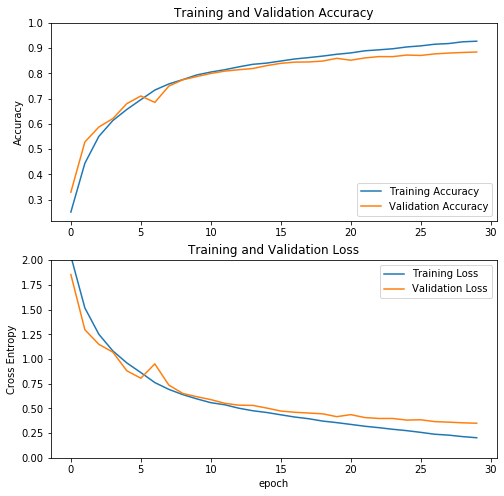

    157/Unknown - 2s 12ms/step - loss: 0.3498 - accuracy: 0.8848Test loss:      0.3498011058682849
Test accuracy:  0.8848


In [8]:
benchmark(wrn, dataset_test, hist, 'wide_residual_network')

## Comparison w Resnet

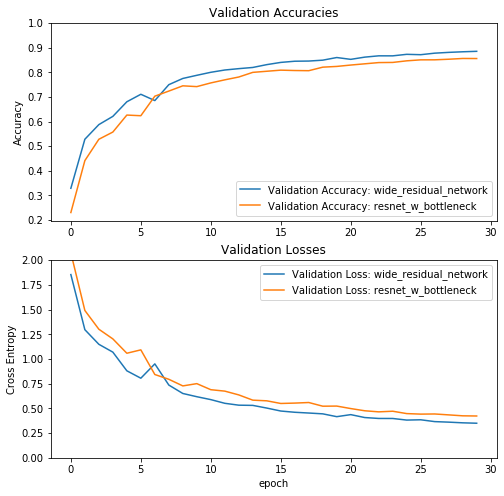

In [9]:
model_names = ['wide_residual_network', 'resnet_w_bottleneck']
plot_multiple_training_curves(model_names)

### Comparing speed of execution

Wider ResNets are faster, more parallelism in execution with GPU.

In [10]:
resnet = tf.keras.models.load_model(SAVE_MODEL_PATH+'/resnet_w_bottleneck/')

In [17]:
timeit(resnet, dataset_test, steps=100)

..........
100 batches: 0.04237477779388428s/batch


In [18]:
timeit(wrn, dataset_test, steps=100)

..........
100 batches: 0.03732157230377197s/batch
